# Covid-19: From model prediction to model predictive control

## Calibration of the age-stratified deterministic model (1)

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook was made to quickly perform scenario analysis with the age-stratified model implementation.

### Load required packages

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
import datetime
import scipy
from scipy.integrate import odeint
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st
import networkx # to install networkx in your environment: conda install networkx
from covid19model.models import models
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import polymod
from covid19model.data import parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2
import math
import xarray as xr
import emcee
from covid19model.optimization import objective_fcns
from covid19model.optimization import MCMC

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load interaction matrices

In [83]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = polymod.get_interaction_matrices()
levels = initN.size

In [84]:
params = parameters.get_COVID19_SEIRD_parameters()
params.update({'l': 7})
initial_states = {'S': initN, 'E': np.ones(levels)}
from covid19model.models.compliance import ramp_1
model = models.COVID19_SEIRD(initial_states, params, compliance=ramp_1)

### Scrape high-level Sciensano data

In [85]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano.head()

,H_tot,ICU_tot,H_in,H_out,H_tot_cumsum,D_tot,D_25_44,D_45_64,D_65_74,D_75_84,D_85+
DATE,,,,,,,,,,,
2020-03-15,266,54,71,18,53,6,0.0,0.0,3.0,1,2
2020-03-16,370,79,90,14,129,11,0.0,0.0,3.0,3,5
2020-03-17,497,100,122,31,220,12,0.0,0.0,1.0,4,7
2020-03-18,650,131,179,48,351,22,1.0,1.0,2.0,6,10
2020-03-19,844,165,207,49,509,28,0.0,0.0,8.0,5,14


### Calibrating $\beta$ and lag_time

**Skip this section when parameters were previously calibrated**

Use the function fit_pso to obtain a good first estimate for the MCMC sampler.

In [7]:
# define dataset
data=[df_sciensano["H_in"].values[:7]]
# set optimisation settings
parNames = ['sigma_H_in','extraTime','beta'] # must be a list!
states = [["H_in"]]
bounds=((1,20),(30,55),(0.02,0.06)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,maxiter=100,popsize=100)

No constraints given.
Best after iteration 1: [19.94584425 34.09877562  0.0569768 ] 28.139523827469386
New best for swarm at iteration 2: [13.36048378 33.47997608  0.06      ] 26.284408113018216
Best after iteration 2: [13.36048378 33.47997608  0.06      ] 26.284408113018216
New best for swarm at iteration 3: [20.         43.09541658  0.04543053] 23.480152061064718
Best after iteration 3: [20.         43.09541658  0.04543053] 23.480152061064718
New best for swarm at iteration 4: [18.77026131 39.18433078  0.04988849] 22.543947781502553
Best after iteration 4: [18.77026131 39.18433078  0.04988849] 22.543947781502553
Best after iteration 5: [18.77026131 39.18433078  0.04988849] 22.543947781502553
Best after iteration 6: [18.77026131 39.18433078  0.04988849] 22.543947781502553
Best after iteration 7: [18.77026131 39.18433078  0.04988849] 22.543947781502553
Best after iteration 8: [18.77026131 39.18433078  0.04988849] 22.543947781502553
Best after iteration 9: [18.77026131 39.18433078  0.04

New best for swarm at iteration 78: [13.53402723 38.33665843  0.05137104] 21.736682865676222
Best after iteration 78: [13.53402723 38.33665843  0.05137104] 21.736682865676222
Best after iteration 79: [13.53402723 38.33665843  0.05137104] 21.736682865676222
New best for swarm at iteration 80: [13.53451642 38.33783692  0.05137103] 21.73668285510642
Best after iteration 80: [13.53451642 38.33783692  0.05137103] 21.73668285510642
Best after iteration 81: [13.53451642 38.33783692  0.05137103] 21.73668285510642
Best after iteration 82: [13.53451642 38.33783692  0.05137103] 21.73668285510642
Best after iteration 83: [13.53451642 38.33783692  0.05137103] 21.73668285510642
Best after iteration 84: [13.53451642 38.33783692  0.05137103] 21.73668285510642
Best after iteration 85: [13.53451642 38.33783692  0.05137103] 21.73668285510642
Best after iteration 86: [13.53451642 38.33783692  0.05137103] 21.73668285510642
Best after iteration 87: [13.53451642 38.33783692  0.05137103] 21.73668285510642
Bes

In [8]:
lag_time = int(round(theta[1]))
model.extraTime = int(round(theta[1]))

model.parameters.update({
    'beta': theta[2],
}
)

start_date = '15-03-2020'

Initiatize and run the MCMC sampler

In [9]:
parNames = ['sigma_ICU','beta'] # must be a list!
bounds=((1,100),(0.01,0.10))

pos = [theta[0],theta[2]] + [1, 1e-2 ]* np.random.randn(4, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [09:09<00:00,  9.11it/s]


In [10]:
samples = sampler.get_chain(discard=100,flat=False)
flat_samples = sampler.get_chain(discard=100,flat=True)

In [11]:
sampler.get_autocorr_time()

array([40.94028439, 29.99751267])

In [11]:
mean = np.mean(flat_samples[:,1])
p10 = np.percentile(flat_samples[:,1],10)
p90 = np.percentile(flat_samples[:,1],90)
print(mean,p10,p90)

0.037688389837820795 0.037483043296351846 0.03788686979236626


Initialize a dictionary of samples and write them to `parameters.json`

In [12]:
samples_dict={'lag_time': int(round(theta[1])), 'beta': flat_samples[:,1].tolist()}

In [13]:
import json

with open('parameters_deterministic.json', 'w') as fp:
    json.dump(samples_dict, fp)

Make some diagnostic visualisations

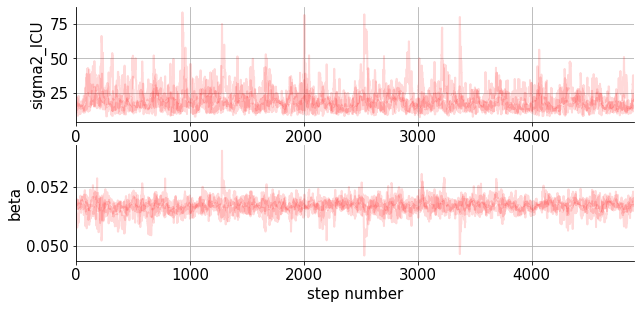

In [14]:
traceplot(samples,labels=["sigma2_ICU","beta"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

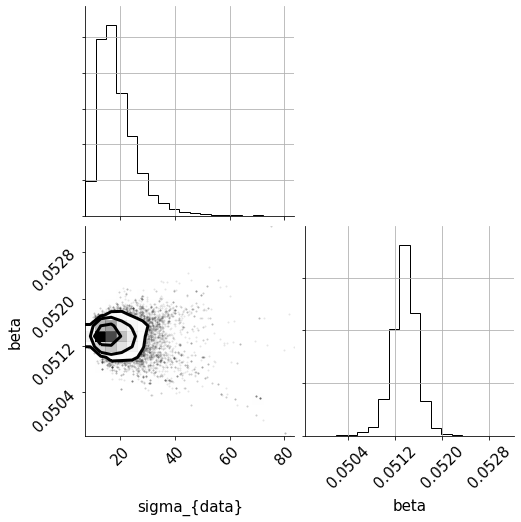

In [53]:
import corner

fig = corner.corner(
    flat_samples,labels=['sigma_{data}','beta']
);
fig.set_size_inches(8, 8)
plt.savefig('corner.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

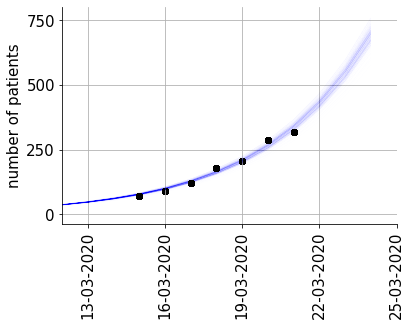

In [61]:
T = 3
fig,ax=plt.subplots()
for i in range(500):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    y_model = model.sim(data[0].size+lag_time-1+T)
    ax = plot_fit(y_model,data,start_date,lag_time,states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 0.05,'alpha': 0.05})


plt.savefig('plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

### Calibrating the compliance function parameter l

#### Loading $\beta$ and lag_time

Load the previously calibrated parameters.

In [5]:
import json
with open('parameters_deterministic.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])

In [6]:
samples_beta = {'beta': samples_dict['beta']}

#### Initial guess for MCMC with PSO

In [7]:
# Create checkpoints dictionary
chk = {'time':  [lag_time], 
       'Nc':    [0.2*Nc_home + ((1-0.70)*Nc_work + (1-0.80)*Nc_transport)],
      }
# checkpoints are hardcoded!

# define dataset
data=[df_sciensano["H_in"].values[:37]]
# set optimisation settings
parNames = ['sigma_H_in','l','prevention'] # must be a list!
states = [["H_in"]]
bounds=((1,100),(1,20),(0.1,1)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,checkpoints=chk,samples=samples_beta,maxiter=100,popsize=50)

No constraints given.
New best for swarm at iteration 1: [73.83945548  7.16621983  0.32601251] 174.02253784682208
Best after iteration 1: [73.83945548  7.16621983  0.32601251] 174.02253784682208
Best after iteration 2: [73.83945548  7.16621983  0.32601251] 174.02253784682208
New best for swarm at iteration 3: [70.62325688  8.41911158  0.22194066] 172.56892966159936
Best after iteration 3: [70.62325688  8.41911158  0.22194066] 172.56892966159936
Best after iteration 4: [70.62325688  8.41911158  0.22194066] 172.56892966159936
New best for swarm at iteration 5: [80.72725552 10.19215578  0.15129582] 172.15801894664412
Best after iteration 5: [80.72725552 10.19215578  0.15129582] 172.15801894664412
Best after iteration 6: [80.72725552 10.19215578  0.15129582] 172.15801894664412
Best after iteration 7: [80.72725552 10.19215578  0.15129582] 172.15801894664412
Best after iteration 8: [80.72725552 10.19215578  0.15129582] 172.15801894664412
New best for swarm at iteration 9: [75.03765166  9.416

Best after iteration 81: [58.61137159  9.45765254  0.22068337] 167.0826350948306
Best after iteration 82: [58.61137159  9.45765254  0.22068337] 167.0826350948306
Best after iteration 83: [58.61137159  9.45765254  0.22068337] 167.0826350948306
Best after iteration 84: [58.61137159  9.45765254  0.22068337] 167.0826350948306
New best for swarm at iteration 85: [57.71445763  9.4347052   0.22472815] 167.0610818460071
Best after iteration 85: [57.71445763  9.4347052   0.22472815] 167.0610818460071
Best after iteration 86: [57.71445763  9.4347052   0.22472815] 167.0610818460071
Best after iteration 87: [57.71445763  9.4347052   0.22472815] 167.0610818460071
Best after iteration 88: [57.71445763  9.4347052   0.22472815] 167.0610818460071
Best after iteration 89: [57.71445763  9.4347052   0.22472815] 167.0610818460071
Best after iteration 90: [57.71445763  9.4347052   0.22472815] 167.0610818460071
Best after iteration 91: [57.71445763  9.4347052   0.22472815] 167.0610818460071
Best after iterat

In [8]:
model.parameters.update({
    'l': theta[1],
}
)
prevention = theta[2]
# Create checkpoints dictionary
chk = {'time':  [lag_time], 
       'Nc':    [0.2*Nc_home + prevention*((1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)],
      }

In [9]:
bounds=((1,100),(1,20),(0.1,1)) # must be a list!
pos = theta + [1, 1e-1, 1e-1 ]* np.random.randn(6, 3)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,chk,samples_beta))
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [48:44<00:00,  3.42it/s]


In [10]:
sampler.get_autocorr_time()

array([120.02085109, 106.89194506,  78.37909232])

In [11]:
samples = sampler.get_chain(discard=200,flat=False)
flat_samples = sampler.get_chain(discard=200,flat=True)

In [12]:
#samples_dict.update({'k': flat_samples[:,1].tolist(), 't0': flat_samples[:,2].tolist(),'prevention':flat_samples[:,3].tolist()})
samples_dict.update({'l': flat_samples[:,1].tolist(),'prevention':flat_samples[:,2].tolist()})

In [14]:
import json

with open('parameters_deterministic.json', 'w') as fp:
    json.dump(samples_dict, fp)

In [18]:
mean = np.mean(flat_samples[:,2])
p10 = np.percentile(flat_samples[:,2],10)
p90 = np.percentile(flat_samples[:,2],90)
print(mean,p10,p90)

0.6349150380542461 0.4942712390265831 0.7622050805358451


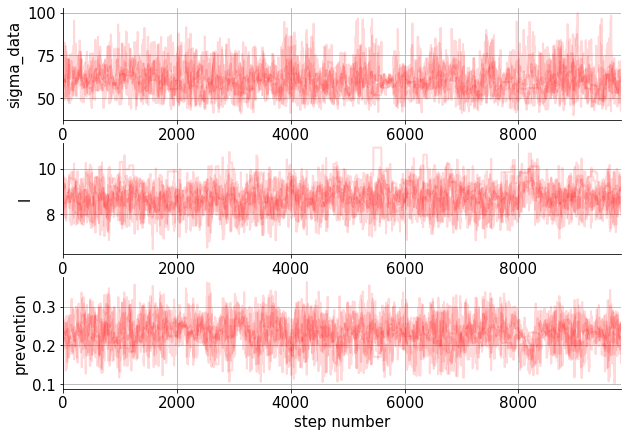

In [15]:
traceplot(samples=sampler.get_chain(discard=200),labels=["sigma_data","l","prevention"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

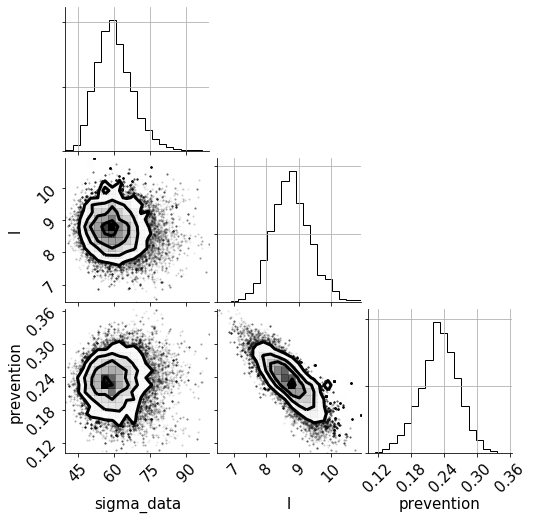

In [16]:
import corner

fig = corner.corner(
    flat_samples, labels=["sigma_data","l","prevention"],
);

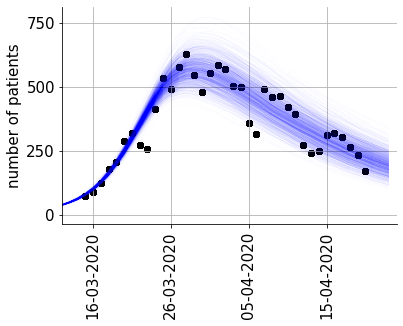

In [18]:
T = 3
start_date = '15-03-2020'
fig,ax=plt.subplots()
for i in range(1000):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    model.parameters['l'] = np.random.choice(samples_dict['l'],1,replace=False)
    prevention = np.random.choice(samples_dict['prevention'],1,replace=False)
    # Create checkpoints dictionary
    chk = {'time':  [lag_time], 
           'Nc':    [0.2*Nc_home + prevention*((1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)],
          }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,start_date,lag_time,states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 0.25,'alpha': 0.05})

### Calibration of hospitalization parameters

Load the previously calibrated parameters: $\beta$, lag_time, k, t0, prevention

In [19]:
import json
with open('parameters_deterministic.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])
model.parameters['l'] = np.mean(samples_dict['l'])
#model.parameters['k'] = np.mean(samples_dict['k'])
#model.parameters['t0'] = np.mean(samples_dict['t0'])
prevention = np.mean(samples_dict['prevention'])

In [21]:
# Create checkpoints dictionary
chk = {'time':  [lag_time], 
       'Nc':    [0.2*Nc_home + prevention*((1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)],
      }

model.parameters['dICUrec'] = 7

# define dataset
data=[df_sciensano["H_out"].values[:55],df_sciensano["ICU_tot"].values[:55],df_sciensano["H_tot"].values[:55]]
# set optimisation settings
parNames = ['sigma_H_out','sigma_ICU_tot','sigma_H_tot','dc','dICU'] # must be a list!
states = [["H_out"],["ICU"],["H_tot"]]
bounds=((1,200),(1,300),(1,600),(8,30),(5,20)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,checkpoints=chk,maxiter=50,popsize=100)

No constraints given.
Best after iteration 1: [160.14757716 234.01692864 211.05490686  13.85738654   8.40142056] 916.5917342346854
Best after iteration 2: [160.14757716 234.01692864 211.05490686  13.85738654   8.40142056] 916.5917342346854
New best for swarm at iteration 3: [130.30278111 240.48980408 321.96248809  15.13329358   8.20467982] 916.1509243684623
Best after iteration 3: [130.30278111 240.48980408 321.96248809  15.13329358   8.20467982] 916.1509243684623
Best after iteration 4: [130.30278111 240.48980408 321.96248809  15.13329358   8.20467982] 916.1509243684623
Best after iteration 5: [130.30278111 240.48980408 321.96248809  15.13329358   8.20467982] 916.1509243684623
New best for swarm at iteration 6: [110.81469562 235.51076165 228.29502288  16.05413452   7.40289286] 906.5698367217551
Best after iteration 6: [110.81469562 235.51076165 228.29502288  16.05413452   7.40289286] 906.5698367217551
New best for swarm at iteration 7: [136.41348919 180.52142056 132.83476323  15.31313

New best for swarm at iteration 47: [103.51324456  99.04152199 163.35584489  14.94811776   8.15716581] 870.2907594308829
Best after iteration 47: [103.51324456  99.04152199 163.35584489  14.94811776   8.15716581] 870.2907594308829
Best after iteration 48: [103.51324456  99.04152199 163.35584489  14.94811776   8.15716581] 870.2907594308829
New best for swarm at iteration 49: [103.44060384  98.95349067 162.57296747  14.94846018   8.15341601] 870.2901020959055
Best after iteration 49: [103.44060384  98.95349067 162.57296747  14.94846018   8.15341601] 870.2901020959055
New best for swarm at iteration 50: [103.46392155  99.20643612 162.6338036   14.94781743   8.15650504] 870.289762098181
Best after iteration 50: [103.46392155  99.20643612 162.6338036   14.94781743   8.15650504] 870.289762098181
Stopping search: maximum iterations reached --> 50


Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/util.py", line 201, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/pool.py", line 689, in _terminate_pool
    cls._help_stuff_finish(inqueue, task_handler, len(pool))
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/pool.py", line 674, in _help_stuff_finish
    inqueue._rlock.acquire()
KeyboardInterrupt: 
Process ForkPoolWorker-33:
Process ForkPoolWorker-30:
Process ForkPoolWorker-25:
Process ForkPoolWorker-26:
Process ForkPoolWorker-27:
Process ForkPoolWorker-24:
Process ForkPoolWorker-31:
Process ForkPoolWorker-32:
Process ForkPoolWorker-29:
Process ForkPoolWorker-28:
Traceback (most recent call last):
Process ForkPoolWorker-23:
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remain

In [22]:
model.parameters.update({
    'dc': theta[3],
    'dICU': theta[4],
}
)

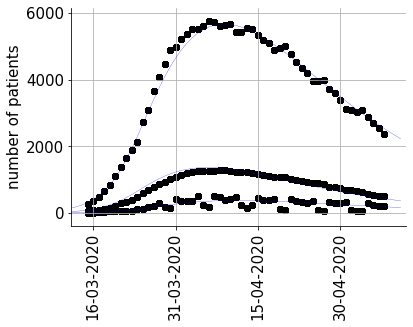

In [23]:
T = 3
fig,ax=plt.subplots()
for i in range(10):
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 0.25,'alpha': 0.10})

In [25]:
pos = theta + [5,5,5,3,3]* np.random.randn(10, 5)
bounds=((1,300),(1,400),(1,800),(1,30),(1,30)) 
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,chk))
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [1:29:53<00:00,  1.85it/s]


In [26]:
sampler.get_autocorr_time()

array([64.58084434, 64.1976943 , 70.85927385, 65.19840255, 61.55311386])

In [29]:
samples = sampler.get_chain(discard=200,flat=False)
flat_samples = sampler.get_chain(discard=200,flat=True)

In [27]:
mean = np.mean(samples_dict['dICU'])
p10 = np.percentile(samples_dict['dICU'],10)
p90 = np.percentile(samples_dict['dICU'],90)
print(mean,p10,p90)

KeyError: 'dICU'

In [30]:
samples_dict.update({'dc': flat_samples[:,3].tolist(), 'dICU': flat_samples[:,4].tolist()})

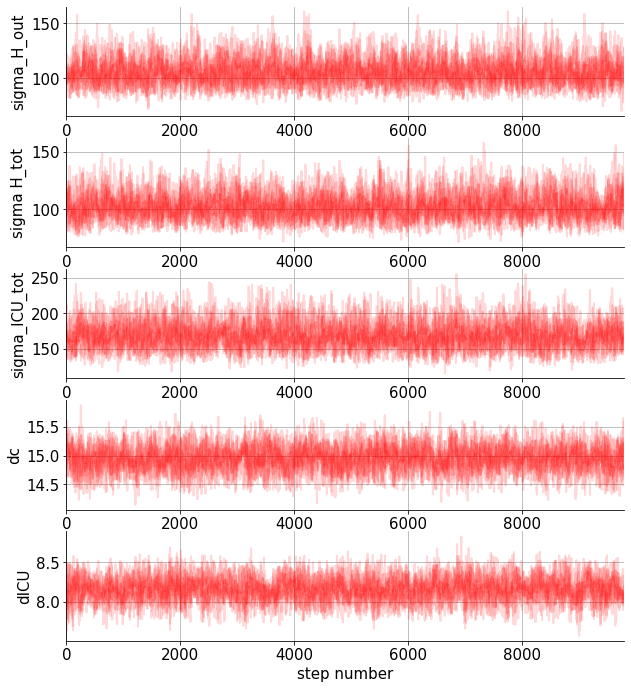

In [32]:
traceplot(samples=sampler.get_chain(discard=200),labels=["sigma_H_out","sigma H_tot","sigma_ICU_tot","dc","dICU"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

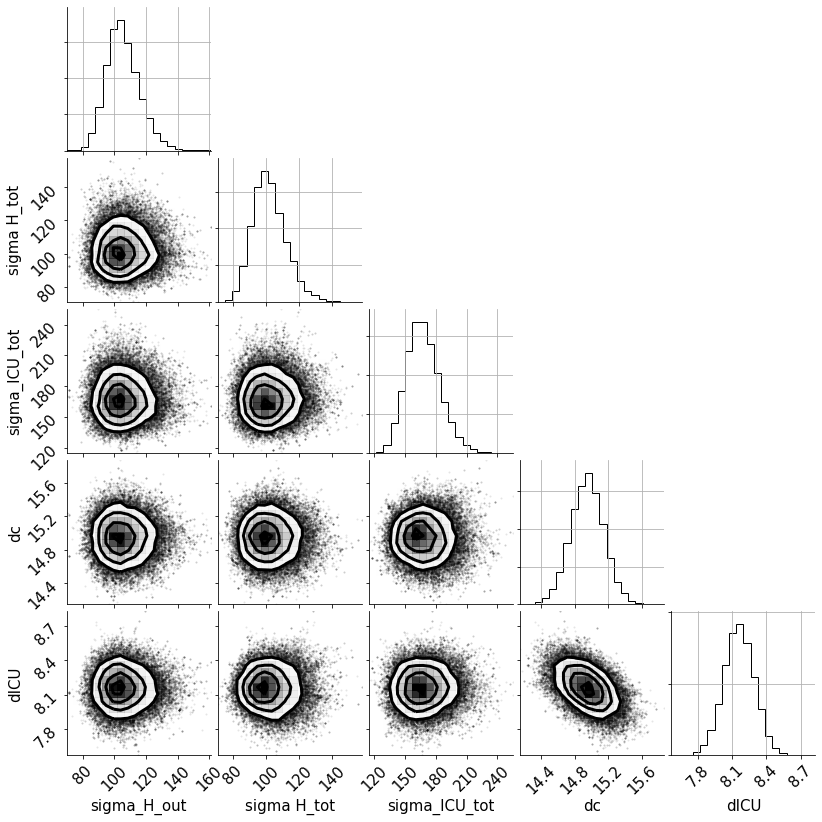

In [33]:
import corner

fig = corner.corner(
    flat_samples, labels=["sigma_H_out","sigma H_tot","sigma_ICU_tot","dc","dICU"],
);

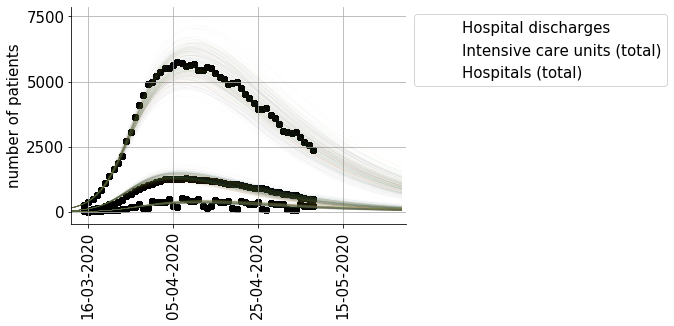

In [35]:
T = 21

fig,ax=plt.subplots()
for i in range(300):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    model.parameters['l'] = np.random.choice(samples_dict['l'],1,replace=False)
    prevention = np.random.choice(samples_dict['prevention'],1,replace=False)
    model.parameters['dc'] = np.random.choice(samples_dict['dc'],1,replace=False)
    model.parameters['dICU'] = np.random.choice(samples_dict['dICU'],1,replace=False)
    # Create checkpoints dictionary
    chk = {'time':  [lag_time], 
           'Nc':    [0.2*Nc_home + prevention*((1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)],
      }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,
                  legend_text=['Hospital discharges','Intensive care units (total)','Hospitals (total)'],
                  plt_kwargs={'linewidth': 0.10,'alpha': 0.15})

In [36]:
import json

with open('parameters_deterministic.json', 'w') as fp:
    json.dump(samples_dict, fp)

# Notebook works till here

### Scenarios

In [86]:
import json
with open('parameters_deterministic.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])
model.parameters['l'] = np.mean(samples_dict['l'])
prevention = np.mean(samples_dict['prevention'])
model.parameters['dc'] = np.mean(samples_dict['dc'])
model.parameters['dICU'] = np.mean(samples_dict['dICU'])

In [87]:
data=[df_sciensano["H_in"].values[:],df_sciensano["H_out"].values[:]]
states = [["H_in"],["H_out"]]

In [88]:
# Define data as a list containing data timeseries
index = pd.date_range('15-03-2020',freq='D',periods=data[0].size + lag_time + T)
print(index[1],index[50],index[52],index[57],index[64],index[81],index[108],index[170])

2020-03-16 00:00:00 2020-05-04 00:00:00 2020-05-06 00:00:00 2020-05-11 00:00:00 2020-05-18 00:00:00 2020-06-04 00:00:00 2020-07-01 00:00:00 2020-09-01 00:00:00


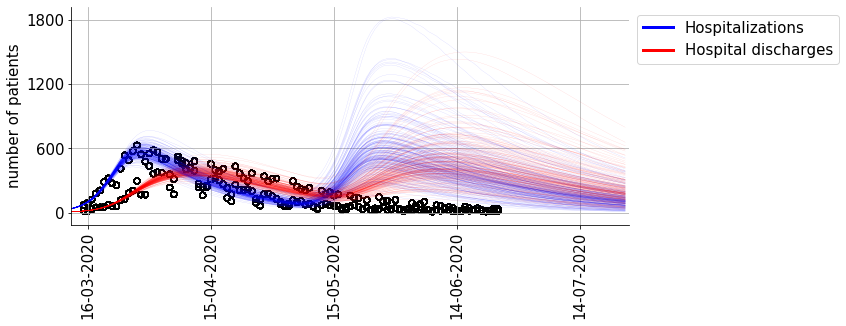

In [92]:
T = 31

fig,ax=plt.subplots()
for i in range(200):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    model.parameters['l'] = np.random.choice(samples_dict['l'],1,replace=False)
    prevention = np.random.choice(samples_dict['prevention'],1,replace=False)
    model.parameters['dc'] = np.random.choice(samples_dict['dc'],1,replace=False)
    model.parameters['dICU'] = np.random.choice(samples_dict['dICU'],1,replace=False)
    # Create a dictionary of past policies
    chk = {'time':   [lag_time,lag_time+50,lag_time+52,lag_time+57], 
          'Nc':      [0.2*Nc_home + prevention*((1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure),
                      0.2*Nc_home + prevention*((1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure),
                      0.3*Nc_home + prevention*((1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure),
                      0.3*Nc_home + prevention*((1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure),]
                              #0.2*Nc_home + prevention*((1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.85)*Nc_schools + (1-0.15)*Nc_others + (1-0.50)*Nc_leisure),
                              #0.2*Nc_home + prevention*((1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.35)*Nc_schools + (1-0.10)*Nc_others + (1-0.30)*Nc_leisure),
                              #0.2*Nc_home + prevention*((1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure)]
                  }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,
                  legend_text=None,
                  plt_kwargs={'linewidth': 0.25,'alpha': 0.20})

legend_text=['Hospitalizations','Hospital discharges']
leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
for lh in leg.get_lines(): 
    lh.set_alpha(1)
fig.set_size_inches(10, 4)
plt.savefig('scenarios_future.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')
plt.savefig('scenarios_future.svg', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

In [ ]:
fig,ax=plt.subplots()
for i in range(400):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    model.parameters['l'] = np.random.choice(samples_dict['l'],1,replace=False)
    prevention = np.random.choice(samples_dict['prevention'],1,replace=False)
    model.parameters['dc'] = np.random.choice(samples_dict['dc'],1,replace=False)
    model.parameters['dICU'] = np.random.choice(samples_dict['dICU'],1,replace=False)
    # Create a dictionary of past policies
    chk = {'time':   [lag_time,lag_time+50,lag_time+52,lag_time+57], 
          'Nc':      [0.2*Nc_home + prevention*((1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure),
                      0.2*Nc_home + prevention*((1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure),
                      0.3*Nc_home + prevention*((1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure),
                      0.3*Nc_home + prevention*((1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure),]
                              #0.2*Nc_home + prevention*((1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.85)*Nc_schools + (1-0.15)*Nc_others + (1-0.50)*Nc_leisure),
                              #0.2*Nc_home + prevention*((1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.35)*Nc_schools + (1-0.10)*Nc_others + (1-0.30)*Nc_leisure),
                              #0.2*Nc_home + prevention*((1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure)]
                  }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax.plot(1-y_model["S"][:,lag_time+15]/y_model["S"][:,0],alpha=0.2,color='blue',linewidth=0.1)
    ax.plot(1-y_model["S"][:,lag_time+36]/y_model["S"][:,0],alpha=0.2,color='red',linewidth=0.1)